# Imports

In [1]:
# !pip install pgmpy
# !pip install networkx==2.8.8
# !pip install interpret

In [2]:
import pgmpy
import random
import networkx as nx
import pylab as plt
import numpy as np
import pandas as pd
from collections import defaultdict

from decimal import Decimal # For high-precision calculations, like fracturing the probability space
from networks import *

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Example plots of Bayesian networks

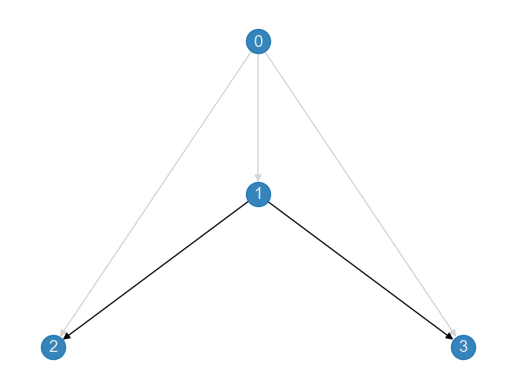

In [3]:
fig, ax = plt.subplots()
B, G = BN_forest([2], ax=ax)
plt.show()

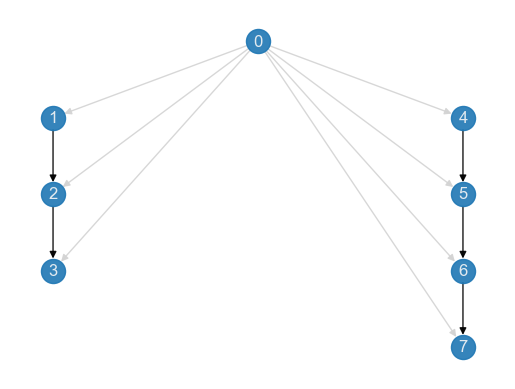

In [4]:
fig, ax = plt.subplots()
B, G = BN_lines([3,4], ax=ax)
plt.show()

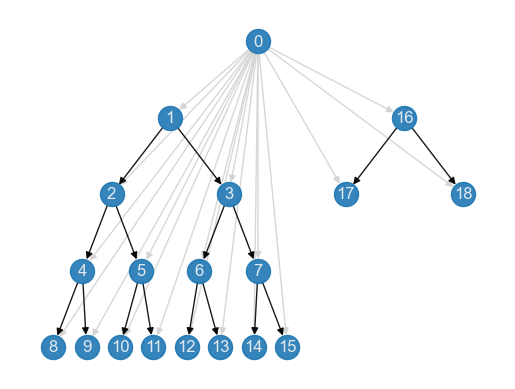

In [7]:
fig, ax = plt.subplots()
B, G = BN_forest([4,2], ax=ax)
plt.show()

In [4]:
# # Sanity check: should add to 0.5

# # total = Decimal(0)
# # best = Decimal(0)
# # prob_1 = Decimal(0.5) # P(y=1)
# # n = 6
# # for i in tqdm(range(2**n)):
# #     num = bin(i)[2:]
# #     num = "0"*(n-len(num)) + num
# #     permutation = [int(digit) for digit in list(num)]
# #     p0 = bn.permutation_probability(0, permutation)
# #     p1 = bn.permutation_probability(0, permutation)
# #     if ebm.predict(np.asarray(permutation))[0] == 0:
# #         total += p0 * (1-prob_1)
# #     else:
# #         total += p1 * prob_1
# #     best += max(p0 * (1-prob_1),p1 * prob_1) # max(p0,p1)
# # print(total)
# # print(best)

# # P(y|x) = P(y) * P(x|y) / P(x)

# total = Decimal(0)
# best = Decimal(0)
# prob_1 = Decimal(0.5) # P(y=1)
# L = []
# for i in tqdm(range(2**n)):
#     num = bin(i)[2:]
#     num = "0"*(n-len(num)) + num
#     permutation = [int(digit) for digit in list(num)]
#     p0 = bn.permutation_probability(0, permutation)
#     p1 = bn.permutation_probability(1, permutation)
# #     print(p0, p1, p0/p1)
#     L.append(p0/p1)
#     best += max(p0 * (1-prob_1),p1 * prob_1) # max(p0,p1)
# plt.hist(L, bins=20)
# print(L)

# Helper functions

In [46]:
def random_extreme(bound):
    out = np.random.uniform(0,bound)
    if np.random.random() <= 0.5:
        out = 1 - out
    return out


class BN(BayesianNetwork):
    """
    Modified BayesianNetwork. Allows for forward pass with given distributions
    """

    def __init__(self, G, dists = None, seed = None, bounds=(0.3,0.7)):
        """
        Initialize same as BayesianNetwork. Then create/save distributions.
        """
        self.G = G
        super().__init__(self.G)
        self.edges = self.G.edges()
        self.target_edges = [e for e in self.edges if e[0] == 0] # Edges originating at the target
        self.interior_edges = [e for e in self.edges if e[0] != 0] # Edges not originating at the target
        self.free_nodes = [e[1] for e in self.edges if e[1] not in np.asarray(self.interior_edges)[:,1]] # Nodes that depend only on the source
        self.vforward = np.vectorize(self.forward)

        if dists is not None:
            self.dists = dists
        else:
            np.random.seed(seed)
            
            # Probabilities for nodes that depend on interior edges.
            # For each node, there are 2^2 possible distributions; 2 for the value of source * 2 for the value of parent.
            self.dists = {e:np.asarray([random_extreme(bounds[0]) for _ in range(4)]).reshape(2,2) for e in self.interior_edges}
            
            # Probabilities for nodes that depend only on source
            self.dists.update({(0,node):np.asarray([random_extreme(bounds[0]), random_extreme(bounds[0])]) for node in self.free_nodes})
            
        self.polynomial = self.calculate_polynomial()

    def forward(self, y=0, seed=None):
        """
        Given a value `y` for the source node, generate values on each node following the distribution of the Bayesian network.
        """
        np.random.seed(seed)
        defined = {0 : y}
        defined.update({node:int(np.random.uniform() < self.dists[(0,node)][y]) for node in self.free_nodes}) # Define all nodes that depend only on 0.
        while len(defined) != len(self.G):
            for e in self.interior_edges:
                if e[0] in defined and e[1] not in defined:
                    defined[e[1]] = int(np.random.uniform() < self.dists[e][defined[e[0]]][y])
        del defined[0] # No need to return y-value
        result = sorted(defined.items(), key=lambda x: x[0]) # Sort results by node index
        result = np.asarray(result)[:,1] # Only return values, not node indices
        return result

    def generate_dataset(self, y, seed=None):
        """
        Given an array `y` of source nodes, calls `self.forward` on each.
        """
        np.random.seed(seed)
        y = np.asarray(y)
        X = np.asarray([self.forward(row) for row in y])
        X = pd.DataFrame(X, columns=list(range(1,len(self.nodes))))
        return X

    def permutation_probability(self, y, permutation):
        """
        Returns probability of a given truth assignment
        """
        prob = Decimal(1.0)
        for node in self.free_nodes:
            p = Decimal(self.dists[(0,node)][y])
            if permutation[node-1] == 1:
                p = 1 - p
            prob *= p
        for e in self.interior_edges:
            p = Decimal(self.dists[e][permutation[e[0]-1]][y])
            if permutation[e[1]-1] == 1:
                p = 1 - p
            prob *= p
        return prob

    def log_odds(self, e, a, b):
        """
        Helper function for self.calculate_polynomial. Shortcut for log(P(...|C=0)/P(...|C=1)).
        where ... is the probability that edge e between x_1 and x_2 has values a and b, respectively (where a, b are 0 or 1)
        """
        numerator = Decimal(self.dists[e][a][1])
        denominator = Decimal(self.dists[e][a][0])
        if b == 0:
            numerator = 1-numerator
            denominator = 1-denominator
        return (numerator/denominator).ln() # Decimal library uses .ln() for log

    def calculate_polynomial(self):
        """
        Return a polynomial representation of the Bayesian network.
        Called on upon BN initialization and output gets saved as self.polynomial
        """
        poly = defaultdict(Decimal)
        const = Decimal(0)
        
        for node in self.free_nodes: # Nodes that depend only on the source node
            # x * log(p11/p10) + (1-x) log(p01/p00)
            const += ((1-Decimal(self.dists[0,node][0]))/(1-Decimal(self.dists[0,node][0]))).ln()
            poly[f"x_{node}"] += (Decimal(self.dists[0,node][0])/Decimal(self.dists[0,node][0])).ln()
            poly[f"x_{node}"] -= ((1-Decimal(self.dists[0,node][0]))/(1-Decimal(self.dists[0,node][0]))).ln()
            
        for e in self.interior_edges: # Nodes that depend on some other node as well as the source node
            #   log(p001/p000)*(1-x1)(1-x2) + log(p011/p010)*x1*(1-x2) + log(p101/p100)*(1-x1)*x2 + log(p111/p001)*x1*x2
            # = log(p001/p000) 
            #     + x1 * (-log(p001/p000) + log(p011/p010))
            #     + x2 * (-log(p001/p000) + log(p101/p100))
            #     + x1x2 * (log(p001/p000) - log(p011/p010) - log(p101/p100) + log(p111/p001))
            
            # p_abc represents P(X_2=b | X_1=a, C=c)
            # p_a1c is given by self.dists[e][a][c], and p_a0c is given by 1-self.dists[e][a][c]
            
            const += self.log_odds(e, 0, 0)
            poly[f"x_{e[0]}"] += -self.log_odds(e, 0, 0) + self.log_odds(e, 0, 1)
            poly[f"x_{e[1]}"] += -self.log_odds(e, 0, 0) + self.log_odds(e, 1, 0)
            poly[f"x_{e[0]}*x_{e[1]}"] += self.log_odds(e, 0, 0) - self.log_odds(e, 0, 1) - self.log_odds(e, 1, 0) + self.log_odds(e, 1, 1)
        poly["const"] = const
        return poly
    
    def predict_poly(self, permutation):
        """
        Calculate log-odds of a truth assignment
        """
        out = 0
        for name, coef in self.polynomial.items():
            if name == "const":
                out += coef
            elif "*" in name: # Interaction terms
                i, j = name.replace("x_", "").split("*")
                out += permutation[int(i)]*permutation[int(j)]*coef
            else: # Linear terms:
                i = int(name.replace("x_", ""))
                out += permutation[i-1]*coef
        return out

In [47]:
# Test polynomial

bn = BN(G, seed=1, bounds = (0.1, 0.9))

total_prob = Decimal(0)

bn.predict_poly([0]*len(G))

Decimal('-22.10246864231613405279564441')

In [48]:
# # Verify that sum of all probabilities is 2 (1 for y=0, plus 1 for y=1)

# y = np.asarray([(0,1) for _ in range(2000)]).flatten()
# bn = BN(G, seed=1, bounds = (0.1, 0.9))

# total_prob = Decimal(0)

# n = len(G)-1 # Number of non-source nodes
# for i in tqdm(range(2**n)):
#     num = bin(i)[2:]
#     num = "0"*(n-len(num)) + num
#     permutation = [int(digit) for digit in list(num)]
#     total_prob += bn.permutation_probability(0, permutation)
#     total_prob += bn.permutation_probability(1, permutation)
# print(total_prob)

# # 22 nodes (BN_forest([3,4])) gives 1.999999999999999999999998485
# # Error=1.5e-24

# Generate synthetic data for training

Start by generating values for node $C$, then propagate through graph structure

In [49]:
y = np.asarray([(0,1) for _ in range(20_000)]).flatten()
bn = BN(G, seed=1, bounds = (0.1, 0.9))
X = bn.generate_dataset(y, seed=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Fit GA$^2$M

In [50]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier()

In [29]:
bn = BN(G, seed=1, bounds = (0.1, 0.9))
y_test = np.asarray([(0,1) for _ in range(50_000)]).flatten() 
X_test = bn.generate_dataset(y_test, seed=123)
size_list = list(range(1000, 101_000, 1000))
accuracy_list = []
for size in tqdm(size_list):
    y_train = np.asarray([(0,1) for _ in range(size)]).flatten() 
    X_train = bn.generate_dataset(y_train, seed=size)
    
    ebm = ExplainableBoostingClassifier()
    ebm.fit(X_train, y_train)
    
    predictions = ebm.predict(X_test)
    accuracy_list.append(np.sum(predictions==y_test)/len(y_test))
    
plt.plot(size_list, accuracy_list)
plt.show()

KeyboardInterrupt: 

  0%|          | 0/40 [00:00<?, ?it/s]

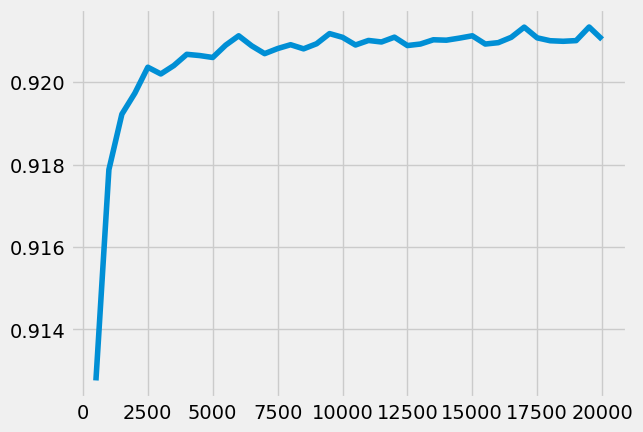

In [71]:
bn = BN(G, seed=1, bounds = (0.1, 0.9))
y_test = np.asarray([(0,1) for _ in range(30_000)]).flatten() 
X_test = bn.generate_dataset(y_test, seed=123)
size_list = list(range(500, 20_500, 500))
accuracy_list = []
n_trials = 5
for size in tqdm(size_list):
    acc = 0
    for t in range(n_trials):
        y_train = np.asarray([(0,1) for _ in range(size)]).flatten() 
        X_train = bn.generate_dataset(y_train, seed=size+t)

        ebm = ExplainableBoostingClassifier()
        ebm.fit(X_train, y_train)

        predictions = ebm.predict(X_test)
        acc += np.sum(predictions==y_test)/len(y_test)
    accuracy_list.append(acc/n_trials)
    
plt.plot(size_list, accuracy_list)
plt.show()

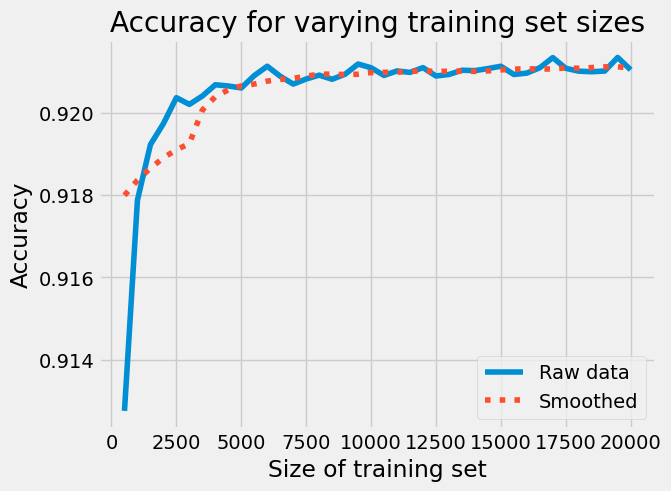

In [78]:
import pandas as pd

# print(size_list)
# # [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000]
# print(accuracy_list)
# # [0.9127599999999999, 0.9178799999999999, 0.9192266666666666, 0.9197366666666665, 0.9203666666666666, 0.9202033333333333, 0.9204066666666668, 0.9206799999999999, 0.92065, 0.9206033333333334, 0.9209033333333332, 0.92113, 0.9208866666666667, 0.9206966666666666, 0.92082, 0.9209133333333333, 0.9208133333333335, 0.9209366666666666, 0.9211833333333332, 0.9210933333333333, 0.9209066666666667, 0.9210166666666666, 0.9209799999999999, 0.9210966666666668, 0.9208933333333335, 0.9209299999999999, 0.9210333333333333, 0.9210233333333333, 0.9210733333333334, 0.92113, 0.9209299999999999, 0.9209633333333332, 0.9210933333333333, 0.92134, 0.9210800000000001, 0.9210100000000001, 0.9209966666666667, 0.9210133333333334, 0.9213433333333333, 0.9210433333333334]
smoothed = pd.DataFrame(accuracy_list).rolling(10, center=True, min_periods=1).mean()
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots()
ax.plot(size_list, accuracy_list, label="Raw data")
ax.plot(size_list, smoothed, label="Smoothed", linestyle=":")
ax.set_xlabel("Size of training set")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy for varying training set sizes")
ax.legend()
plt.show()

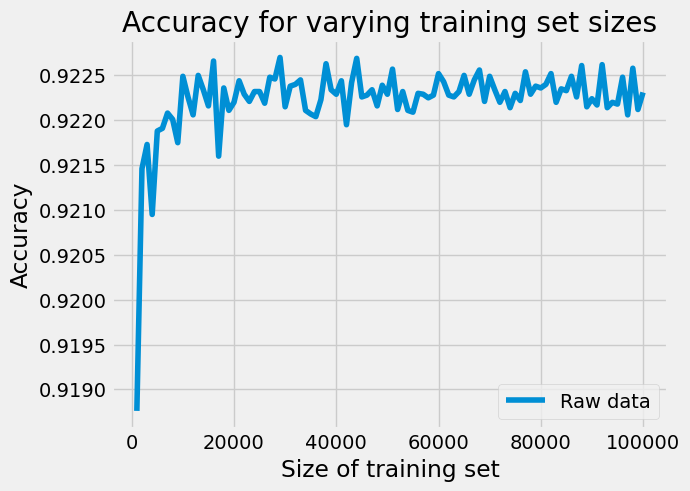

In [69]:
import pandas as pd

# print(size_list)
# [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000]
# print(accuracy_list)
# [0.91876, 0.92146, 0.92173, 0.92095, 0.92188, 0.92191, 0.92208, 0.92201, 0.92175, 0.92249, 0.92226, 0.92206, 0.9225, 0.92234, 0.92216, 0.92266, 0.9216, 0.92236, 0.92211, 0.9222, 0.92244, 0.92229, 0.92221, 0.92232, 0.92232, 0.92219, 0.92248, 0.92246, 0.9227, 0.92215, 0.92238, 0.9224, 0.92245, 0.92211, 0.92207, 0.92204, 0.92223, 0.92263, 0.92234, 0.92229, 0.92244, 0.92195, 0.92242, 0.92269, 0.92226, 0.92228, 0.92234, 0.92216, 0.92239, 0.92229, 0.92257, 0.92212, 0.92232, 0.92211, 0.92209, 0.9223, 0.92229, 0.92225, 0.92228, 0.92252, 0.92243, 0.92228, 0.92226, 0.92232, 0.9225, 0.92229, 0.92245, 0.92256, 0.92221, 0.92249, 0.92234, 0.9222, 0.92232, 0.92214, 0.9223, 0.92222, 0.92254, 0.92229, 0.92238, 0.92236, 0.9224, 0.92252, 0.9222, 0.92235, 0.92233, 0.92249, 0.92226, 0.92261, 0.92215, 0.92224, 0.92217, 0.92262, 0.92214, 0.9222, 0.92218, 0.92248, 0.92206, 0.92258, 0.92212, 0.92231]
smoothed = pd.DataFrame(accuracy_list).rolling(10, center=True, min_periods=1).mean()
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots()
ax.plot(size_list, accuracy_list, label="Raw data")
# ax.plot(size_list, smoothed, label="Smoothed", line~style=":")
ax.set_xlabel("Size of training set")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy for varying training set sizes")
ax.legend()
plt.show()

In [51]:
predictions = ebm.predict(X_test)
print(np.sum(predictions==y_test)/len(y_test))

0.9999


In [52]:
predictions = ebm.predict(X_test)
print(np.sum(predictions==y_test)/len(y_test))

0.9999


In [40]:
total = Decimal(0)
best = Decimal(0)
prob_1 = Decimal(0.5) # P(y=1)
for i in tqdm(range(2**n)):
    num = bin(i)[2:]
    num = "0"*(n-len(num)) + num
    permutation = [int(digit) for digit in list(num)]
    p0 = bn.permutation_probability(0, permutation)
    p1 = bn.permutation_probability(1, permutation)
    if ebm.predict(np.asarray(permutation))[0] == 0:
        total += p0 * (1-prob_1)
    else:
        total += p1 * prob_1
    best += max(p0 * (1-prob_1),p1 * prob_1) # max(p0,p1)
print(total)
print(best)

  0%|          | 0/262144 [00:00<?, ?it/s]

0.1537694503566555524264930435
0.9242489232142366737332302154


In [49]:
show(ebm.explain_global())

<!-- http://127.0.0.1:7001/2005055033984/ -->

In [13]:
show(ebm.explain_local(X_test[:100], y_test[:100]))

<!-- http://127.0.0.1:7001/3121805707296/ -->

# Find polynomial coefficients

In [30]:
def ebm_polynomial(ebm):
    """
    Given GA^2M (EBM) model, return the polynomial giving log-odds
    """
    poly = defaultdict(Decimal)
    const = Decimal(ebm.intercept_[0])
    linear_terms = ebm.term_scores_[:len(G)-1]
    linear_terms = [[Decimal(w) for w in v] for v in linear_terms]
    linear_term_names = [name for name in ebm.term_names_ if "&" not in name]
    inter_terms = ebm.term_scores_[len(G)-1:]
    inter_terms = [[[Decimal(x) for x in w] for w in v] for v in inter_terms]
    inter_term_names = [name.split(" & ") for name in ebm.term_names_ if "&" in name]
    for x_i, term in zip(linear_term_names, linear_terms):
        # f(x) = (term[1] if x==0), (term[2] if x==1)
        # f(x) = (1-x)*(term[1]) + x*(term[2])
        # f(x) = x*(term[2]-term[1]) + term[1]
        poly[f"x_{x_i}"] += term[2]-term[1]
        const += term[1]

    for (x_i, x_j), term in zip(inter_term_names, inter_terms):
        # f(x_i,x_j) = term[1,1] if x_i==0, x_j==0
        #              term[1,2] if x_i==0, x_j==1
        #              term[2,1] if x_i==1, x_j==0
        #              term[2,2] if x_i==1, x_j==1
        # f(x_i,x_j) = x_i*x_j*term[2,2] + x_i*(1-x_j)*term[2,1] + (1-x_i)*x_j*term[1,2] + (1-x_i)*(1-x_j)*term[1,1]
        # f(x_i,x_j) = x_i*x_j*(term[2,2]-term[2,1]-term[1,2]+term[1,1]) + x_i*(term[2,1]-term[1,1]) + x_j*(term[1,2]-term[1,1]) + term[1,1]
        poly[f"x_{x_i}*x_{x_j}"] = term[2][2]-term[2][1]-term[1][2]+term[1][1]
        poly[f"x_{x_i}"] += term[2][1]-term[1][1]
        poly[f"x_{x_j}"] += term[1][2]-term[1][1]
        const += term[1][1]
    poly["const"] = const
    return poly

def predict_poly(poly, vals=[1,1,1,1,1,1,1]):
    """
    For polynomial f, return f(x)
    """
    out = 0
    for name, coef in poly.items():
        if name == "const":
            out += coef
        elif "*" in name: # Interaction terms
            i, j = name.replace("x_", "").split("*")
            out += vals[int(i)-1]*vals[int(j)-1]*coef
        else: # Linear terms:
            i = int(name.replace("x_", ""))
            out += vals[i-1]*coef
    return out

poly = ebm_polynomial(ebm)
print("GAM polynomial:")
for name, term in poly.items():
    print(f"{name} * {term:.2f}")

GAM polynomial:
x_1 * 11.41
x_2 * 7.52
x_3 * 0.58
x_1*x_2 * -7.36
x_1*x_3 * -2.67
x_2*x_3 * 0.32
const * -8.42


In [31]:
print("BN polynomial (GAM poly)")
for name in bn.polynomial.keys():
    if name in poly.keys():
        print(f"{name} * {bn.polynomial[name]:.2f}          ({poly[name]:.2f})")
    else:
        print(f"{name} * {bn.polynomial[name]:.2f}")

BN polynomial (GAM poly)
x_1 * 14.57          (11.41)
x_2 * 11.57          (7.52)
x_1*x_2 * -14.76          (-7.36)
x_3 * 0.02          (0.58)
x_1*x_3 * -2.09          (-2.67)
const * -11.34          (-8.42)


In [24]:
for name, term in bn.polynomial.items():
    print(f"{name} * {term:.2f}")

x_1 * 0.55
x_8 * 2.91
x_2 * 0.40
x_1*x_2 * 0.20
x_3 * 3.48
x_1*x_3 * 0.35
x_4 * -0.04
x_2*x_4 * 0.20
x_5 * -0.40
x_2*x_5 * 0.94
x_6 * 0.47
x_3*x_6 * -1.65
x_7 * 1.01
x_3*x_7 * -2.40
x_9 * 0.02
x_8*x_9 * -1.14
x_10 * 4.13
x_8*x_10 * -3.52
x_11 * 0.10
x_9*x_11 * -0.88
x_12 * -0.02
x_9*x_12 * -0.18
x_13 * 0.06
x_10*x_13 * -0.12
x_14 * 1.37
x_10*x_14 * -2.45
const * -4.03


# Fraction of probability space where both polynomials agree

In [54]:
agreements = 0
n = len(G)
for i in tqdm(range(2**n), mininterval=1.5):
    num = bin(i)[2:]
    num = "0"*(n-len(num)) + num
    permutation = [int(digit) for digit in list(num)]
    
    pred_gam = predict_poly(poly, permutation) # GAM prediction
    pred_bn = predict_poly(bn.polynomial, permutation) # BN prediction
    if (pred_gam > 0) == (pred_bn > 0): # If sign is the same
        p0 = bn.permutation_probability(int(pred_bn>0), permutation)
        p1 = bn.permutation_probability(1-int(pred_bn>0), permutation)
        agreements += p0/(p0+p1)
        
print(agreements)

  0%|          | 0/32768 [00:00<?, ?it/s]

9740.823424867952658823743434


In [31]:
np.random.seed(1)
permutation = np.random.choice([0,1], size=n)
print(permutation)
print(ebm.decision_function(permutation))
print(predict_poly(poly, vals=permutation))

[1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1]
[7.84180306]
7.841803058625783445778623098


In [134]:
# Verify that the polynomial output matches the EBM output across entire input space
for i in tqdm(range(2**n)):
    num = bin(i)[2:]
    num = "0"*(n-len(num)) + num
    permutation = [int(digit) for digit in list(num)]
    prediction_poly = predict_poly(poly, vals=permutation)
    prediction_ebm = Decimal(ebm.decision_function(permutation)[0])
    if np.sign(prediction_poly) != np.sign(prediction_ebm):
        print(permutation)
        print("Polynomial:", prediction_poly)
        print("EBM:       ", prediction_ebm)
        print("Difference:", prediction_poly-prediction_ebm)
        print("Prob:      ", bn.permutation_probability(0, permutation), bn.permutation_probability(1, permutation))
        print("")

  0%|          | 0/32768 [00:00<?, ?it/s]